# MSA 2024 Phase 2 - Part 3 {-}

Welcome to the competition - in Part 3, you are encouraged to utilize neural network based models for classification.

This notebook builds a simple Multi-Layer Perceptron (MLP) model for the CIFAR-10 dataset, with the use of `keras` to define the model structure.

**Before start working on the competition, please ensure all required libraries are installed and properly set up on your system**:

- `python >= 3.6`,
- `tensorFlow >= 2.0`,
- `keras >= 2.3`,

and any neccassary liburaries for data manipulation and processing, e.g., `numpy`, `pandas`, etc.

In [65]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

### 1. Data loading & preprocessing {-}

The CIFAR-10 dataset contains 60,000 images(32x32x3) in 10 different classes, with 6,000 images in each class. You can download the dataset directly from the competition webpage.

**To train the model, you are expected to use the training label provided in train.csv**.

In [66]:
train_dir = './dataset/cifar10_images/train'
test_dir = './dataset/cifar10_images/test'


In [75]:
def loadTrain(root_dir, csv_file):
    ids = []
    images = []
    labels = []
    annotations = np.genfromtxt(csv_file, delimiter=',', names=True)
    for idx in range(len(annotations)):
        img_id = int(annotations['id'][idx])
        img_name = os.path.join(root_dir, f"image_{img_id}.png")
        image = np.array(Image.open(img_name).convert("RGB"))
        label = int(annotations['label'][idx])

        ids.append(img_id)
        images.append(image)
        labels.append(label)
    return np.array(ids), np.array(images), np.array(labels)

def loadTest(root_dir):
    ids = []
    images = []
    for idx in range(len(os.listdir(root_dir))):
        img_name = os.path.join(root_dir, f"image_{idx}.png")
        image = np.array(Image.open(img_name).convert("RGB"))

        ids.append(idx)
        images.append(image)
    return np.array(ids), np.array(images)


# Load training, testing data and the training label provided in train.csv.
train_csv = './dataset/train.csv'
id_train, X_train, y_train = loadTrain(train_dir, train_csv)
id_test, X_test = loadTest(test_dir)

# Normalize the data
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train_split)
std  = np.std(X_train_split)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train_split = (X_train_split-mean)/(std+1e-7)
X_val_split = (X_val_split-mean)/(std+1e-7)

mean_test = np.mean(X_test)
std_test  = np.std(X_test)
X_test  = (X_test-mean_test) /(std_test+1e-7)

# Convert training labels to one-hot encoded vectors.
y_train_split = to_categorical(y_train_split, 10)
y_val_split=  to_categorical(y_val_split, 10)

Print the shape of loaded training and testing sets. The dataset is downloaded from the kaggle competition, it has only 55000 images, 50000 for training and 5000 for testing.

In [68]:
print(X_train_split.shape)
print(y_train_split.shape)
print(X_val_split.shape)
print(y_val_split.shape)
print(X_test.shape)

(45000, 32, 32, 3)
(45000, 10)
(5000, 32, 32, 3)
(5000, 10)
(5000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8888927..1.7583104].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2966118..1.9141738].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7642019..1.8518285].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8888927..1.8206558].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8888927..1.0101662].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.85772..1.8830012].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8888927.

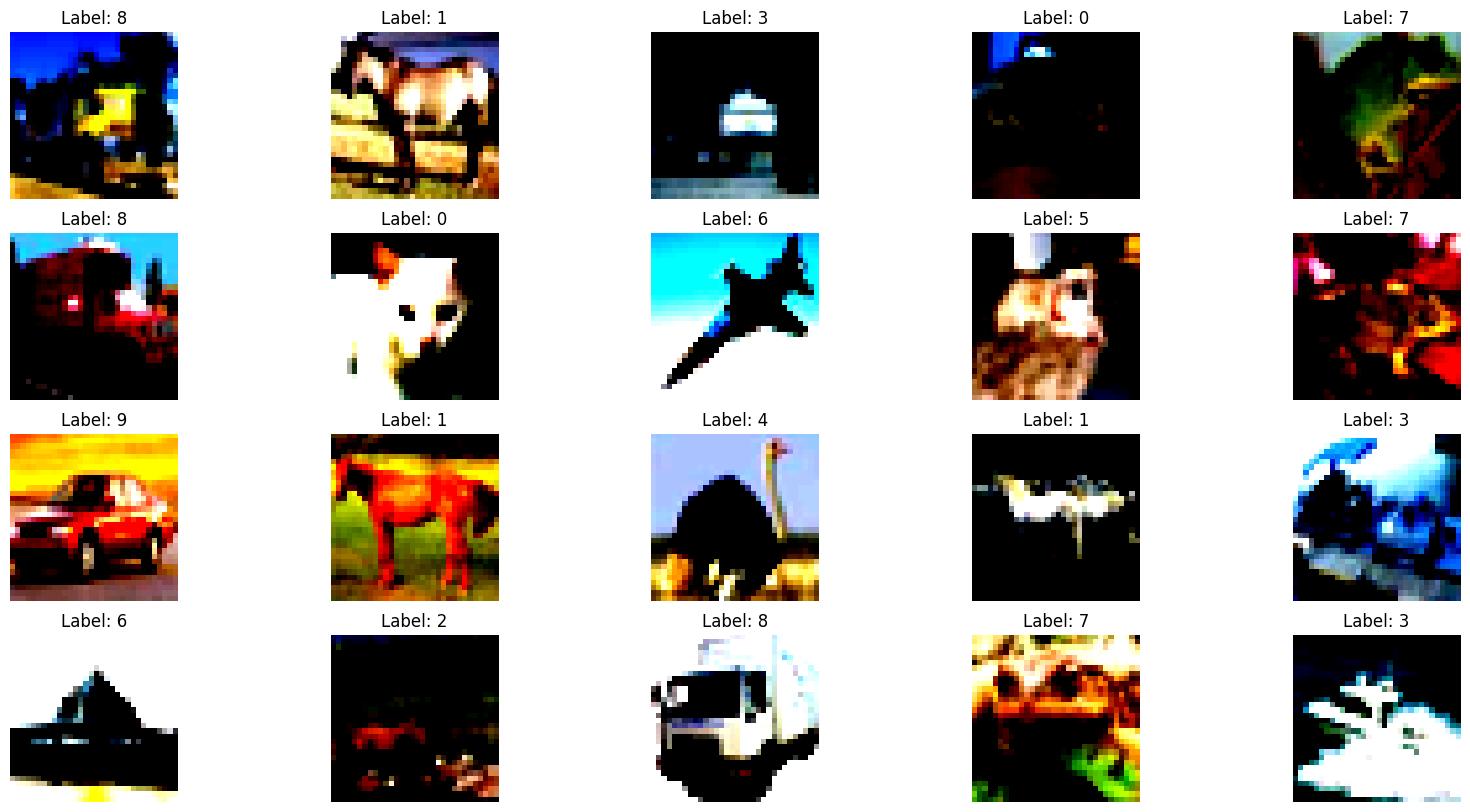

In [69]:
# Plot the first 20 images with their labels
def plot_images(images, labels, num_images=20):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

y_train_labels = np.argmax(y_train_split, axis=1)
plot_images(X_train_split, y_train_labels, num_images=20)

### 2. Build & train the model {-}

I am going to build and train a CNN model.

In [70]:
# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 20 degrees
    rotation_range=20,
    
    # Shift images horizontally by up to 15%
    width_shift_range=0.15,
    
    # Shift images vertically by up to 15% 
    height_shift_range=0.15,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 20%
    zoom_range=0.2,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
)

In [71]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.00008

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.3))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))
model.summary()

/Users/jxiao/Desktop/code/msa/phase2/msa2/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,186,346 (4.53 MB)

 Trainable params: 1,184,426 (4.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [72]:
# Set the batch size for the training
batch_size = 256

# Set the maximum number of epochs for the training
epochs = 300

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.003)

train_generator = data_generator.flow(X_train_split, y_train_split, batch_size=batch_size)
val_generator = data_generator.flow(X_val_split, y_val_split, batch_size=batch_size)



# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callbackå
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 40 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator,
          callbacks=[reduce_lr, early_stopping])

/Users/jxiao/Desktop/code/msa/phase2/msa2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.2614 - loss: 3.0764

/Users/jxiao/Desktop/code/msa/phase2/msa2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 123s 683ms/step - accuracy: 0.2617 - loss: 3.0721 - val_accuracy: 0.2318 - val_loss: 2.5065 - learning_rate: 0.0030
Epoch 2/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 117s 653ms/step - accuracy: 0.4121 - loss: 1.8134 - val_accuracy: 0.4464 - val_loss: 1.6447 - learning_rate: 0.0030
Epoch 3/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 115s 651ms/step - accuracy: 0.4617 - loss: 1.6653 - val_accuracy: 0.3220 - val_loss: 2.1884 - learning_rate: 0.0030
Epoch 4/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 115s 652ms/step - accuracy: 0.4537 - loss: 1.7124 - val_accuracy: 0.4394 - val_loss: 1.9262 - learning_rate: 0.0030
Epoch 5/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 115s 655ms/step - accuracy: 0.4541 - loss: 1.7847 - val_accuracy: 0.3496 - val_loss: 2.1553 - learning_rate: 0.0030
Epoch 6/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 1074s 6s/step - accuracy: 0.4411 - loss: 1.8765 - val_accuracy: 0.5070 - val_loss: 1.5949 - learning_rate: 0.0030
Epoch 7/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 673s 4s/step - accuracy: 0.4876

### 3.Evaluation {-}

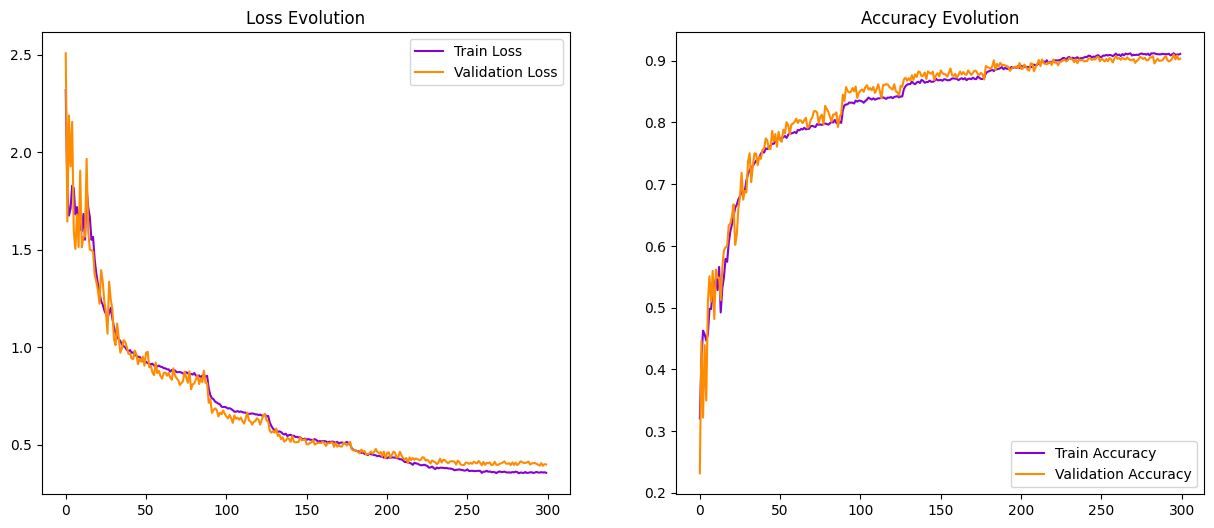

In [73]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

### 4. Export result and model {-}

In [76]:
# Make predictions.
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Prepare your submission file.
submission = np.column_stack((id_test, predicted_labels))
np.savetxt('submission.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [77]:
model.save('cifar_cnn.h5')